In [1]:
import onnxruntime as ort
import glob as gb
import pandas as pd
import numpy as np
from utils.plotting_JPDF import plot_JPDF

rng = np.random.default_rng(0)
import numpy as np
from sklearn.preprocessing import StandardScaler

def signed_log1p(y):
    return np.sign(y) * np.log1p(np.abs(y))

def signed_expm1(y):
    return np.sign(y) * np.expm1(np.abs(y))





In [2]:
# Read the data from the FlameMaster files
fname = './../neural_network/data/chemtable_FVV_2D_Enthalpy/*.kg'
files = gb.glob(fname)
nfiles = len(files)


# Read column names from the second line of the first file
with open(files[0], 'r') as f:
    lines = f.readlines()
    column_names = lines[1].strip().split('\t')  # Read second line (index 1) and split by whitespace

# Create empty lists to store the data
data_flameMaster = []

# Load and concatenate the data into DataFrames
for f in files:

    df_flameMaster_temp = pd.DataFrame(np.loadtxt(f, skiprows=2, dtype=np.float64),columns=column_names)
    data_flameMaster.append(df_flameMaster_temp)

# Concatenate all data into final DataFrames
df_flameMaster_all = pd.concat(data_flameMaster, ignore_index=True)

#Computing diffusivity 
df_flameMaster_all['Diff [kg/ms]'] = df_flameMaster_all['lambda [W/mK]'] / df_flameMaster_all['cp [J/kgK]']

# Select the relevant columns for input and output
input_data = ['ProgVar', 'TotalEnthalpy [J/kg]']
referenceEnthalpy = 276240

# Shift the enthalpy values to be relative to the reference enthalpy
df_flameMaster_all['TotalEnthalpy [J/kg]'] = df_flameMaster_all['TotalEnthalpy [J/kg]'] - referenceEnthalpy

# Select the relevant columns for input and output
output_data = ['ProdRateProgVar [kg/m^3s]', 'temperature [K]', 'Y-CO', 'density', 'mu [kg/ms]', 'cp [J/kgK]', 'Diff [kg/ms]']

# Select a reduced number of data
# n_samples = 10000
# idx = rng.choice(df_flameMaster_all.index, size=n_samples, replace=False)
# df_flameMaster_all = df_flameMaster_all.loc[idx]

# Create DataFrames for input and output data
X_all = df_flameMaster_all[input_data].to_numpy()
Z_all = df_flameMaster_all[output_data].to_numpy()

# Load mask from trained model
#mask = rng.random(len(X_all)) < 0.8 #np.random.choice([True, False], len(X_all), p=[0.80, 0.2])

test_idx = np.load("./splits_uq/test_idx.npy")
train_subsets = np.load("./splits_uq/train_subsets_seed0.npz")
train_idx = train_subsets["train_10000"]

# X_train = X_all[mask].astype(np.float32)
# Z_train = Z_all[mask].astype(np.float32)
# X_test  = X_all[~mask].astype(np.float32)
# Z_test  = Z_all[~mask].astype(np.float32)

X_train = X_all[train_idx].astype(np.float32)
Z_train = Z_all[train_idx].astype(np.float32)
X_test  = X_all[test_idx].astype(np.float32)
Z_test  = Z_all[test_idx].astype(np.float32)

Z_train_t = signed_log1p(Z_train)
Z_test_t  = signed_log1p(Z_test)

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Z_train_t)

X_train_s = x_scaler.transform(X_train)
X_test_s  = x_scaler.transform(X_test)

Z_train_s = y_scaler.transform(Z_train_t)


# x_mean = X_train.mean(axis=0, keepdims=True)
# x_std  = X_train.std(axis=0, keepdims=True) + 1e-12

# X_train_s = (X_train - x_mean) / x_std
# X_test_s  = (X_test  - x_mean) / x_std






In [3]:
import numpy as np
import itertools


# -----------------------------
# RBF kernel (squared exponential)
# -----------------------------
# def rbf_kernel(x, y, sigma_f, l):
#     """
#     x: (2,), y: (2,)
#     """
#     r2 = np.sum((x - y)**2)
#     return (sigma_f**2) * np.exp(-0.5 * r2 / (l**2))


# def compute_cov_matrices(X, X_star, sigma_f, l):
#     """
#     Build:
#       K      : (n, n)
#       K_star : (n_star, n)
#       K_star2: (n_star, n_star)
#     """
#     n = X.shape[0]
#     n_star = X_star.shape[0]

#     # K (train-train)
#     K = [rbf_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(X, X)]
#     K = np.array(K).reshape(n, n)

#     # # K_star2 (test-test)
#     # K_star2 = [rbf_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(X_star, X_star)]
#     # K_star2 = np.array(K_star2).reshape(n_star, n_star)

#     # K_star (test-train)
#     K_star = [rbf_kernel(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(X_star, X)]
#     K_star = np.array(K_star).reshape(n_star, n)

#     return K, K_star2, K_star


# # -----------------------------
# # Posterior parameters (multi-output independent GPs)
# # -----------------------------
# def compute_gpr_parameters(K, K_star2, K_star, sigma_n, Y):
#     """
#     K      : (n, n)
#     K_star2: (n_star, n_star)
#     K_star : (n_star, n)
#     sigma_n: scalar noise std
#     Y      : (n, 7)

#     Returns:
#       f_mean_star: (n_star, 7)
#       cov_f_star : (n_star, n_star)  # same for all outputs here
#     """
#     n = K.shape[0]

#     # Add noise on diagonal for numerical stability and observation noise
#     K_noise = K + (sigma_n**2) * np.eye(n)

#     # IMPORTANT: Use solve instead of explicit inverse (more stable)
#     # alpha = (K + sigma_n^2 I)^(-1) Y
#     alpha = np.linalg.solve(K_noise, Y)              # (n, 7)

#     # Predictive mean: K_* (K_noise^-1 Y)
#     f_mean_star = K_star @ alpha                     # (n_star, 7)

#     # Predictive covariance: K_** - K_* K_noise^-1 K_*^T
#     v = np.linalg.solve(K_noise, K_star.T)           # (n, n_star)
#     cov_f_star = K_star2 - (K_star @ v)              # (n_star, n_star)

#     return f_mean_star, cov_f_star


# # -----------------------------
# # Optional: draw posterior samples for all 7 outputs
# # -----------------------------
# def sample_posterior(f_mean_star, cov_f_star, n_samples=100, rng=None):
#     """
#     f_mean_star: (n_star, 7)
#     cov_f_star : (n_star, n_star)

#     Returns:
#       samples: (n_samples, n_star, 7)
#     """
#     if rng is None:
#         rng = np.random.default_rng(0)

#     n_star, d = f_mean_star.shape
#     samples = np.zeros((n_samples, n_star, d), dtype=np.float64)

#     # Sample each output independently with same cov
#     for j in range(d):
#         samples[:, :, j] = rng.multivariate_normal(
#             mean=f_mean_star[:, j],
#             cov=cov_f_star,
#             size=n_samples
#         )
#     return samples


In [4]:
def rbf_kernel_matrix(Xa, Xb, sigma_f, l):
    Xa = np.asarray(Xa, dtype=np.float64)
    Xb = np.asarray(Xb, dtype=np.float64)
    a2 = np.sum(Xa**2, axis=1, keepdims=True)
    b2 = np.sum(Xb**2, axis=1, keepdims=True).T
    sqdist = a2 + b2 - 2.0*(Xa @ Xb.T)
    return (sigma_f**2) * np.exp(-0.5 * sqdist / (l**2))

def gp_mean_exact(X_train_s, Y_train_s, X_test_s, sigma_f, l, sigma_n):
    N = X_train_s.shape[0]
    K = rbf_kernel_matrix(X_train_s, X_train_s, sigma_f, l)
    K[np.diag_indices(N)] += sigma_n**2

    L = np.linalg.cholesky(K)
    v = np.linalg.solve(L, Y_train_s)
    alpha = np.linalg.solve(L.T, v)

    K_star = rbf_kernel_matrix(X_test_s, X_train_s, sigma_f, l)
    return K_star @ alpha  # mean in scaled output space


In [5]:

# Hyperparameters
l = 0.2           # length-scale
sigma_f = 1.0     # signal std (note squared in kernel)
sigma_n = 1e-3    # observation noise std (small if surrogate is "noise-free")

# Build cov matrices
Z_pred_s = gp_mean_exact(X_train_s, Z_train_s, X_test_s, sigma_f, l, sigma_n)

# Posterior mean/cov
#Z_mean_star, cov_Z_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n=sigma_n, Y=Z_train)

# Posterior samples (optional)
#samples = sample_posterior(f_mean_star, cov_f_star, n_samples=100, rng=rng)

Z_pred_t = y_scaler.inverse_transform(Z_pred_s)   # back to signed_log1p space
Z_pred   = signed_expm1(Z_pred_t)                # physical

Z_test_phys = Z_test  # already physical




ProdRateProgVar [kg/m^3s]      rRMSE_phys = 2.6853 %
temperature [K]                rRMSE_phys = 0.0150 %
Y-CO                           rRMSE_phys = 0.3261 %
density                        rRMSE_phys = 0.0235 %
mu [kg/ms]                     rRMSE_phys = 0.0182 %
cp [J/kgK]                     rRMSE_phys = 0.0481 %
Diff [kg/ms]                   rRMSE_phys = 0.0173 %
R2: 0.9993, NMSE: 0.0006714489615149411


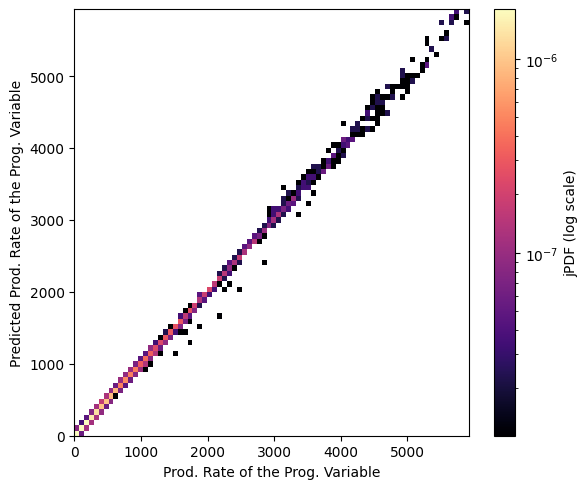

In [6]:
# NMSE per output: mean((e^2)) / mean((y_true^2))
eps = 1e-12
rRMSE_phys = np.sqrt(np.mean((Z_pred - Z_test_phys)**2, axis=0)) / (Z_test_phys.std(axis=0) + eps)

for name, e in zip(output_data, rRMSE_phys):
    print(f"{name:30s} rRMSE_phys = {100*e:.4f} %")


plot_JPDF(
    df_true=Z_test_phys[:, 0],
    df_pred=Z_pred[:, 0],
    bins=80,
    x_label="Prod. Rate of the Prog. Variable",
    y_label="Predicted Prod. Rate of the Prog. Variable",
)


In [7]:
# import numpy as np
# import os

# def make_splits_and_subsets(N_total, test_frac, train_sizes, seeds, out_dir, base_seed=123):
#     """
#     Creates:
#       - test_idx.npy
#       - train_pool_idx.npy
#       - train_subsets_seed{seed}.npz  (contains train_{N} arrays)

#     Parameters
#     ----------
#     N_total : int
#         Total number of samples in the full dataset (e.g., 80000)
#     test_frac : float
#         Fraction for test set (e.g., 0.2)
#     train_sizes : list[int]
#         Training sizes to benchmark (e.g., [10000,20000,...,64000])
#     seeds : list[int]
#         Seeds for repeated experiments (e.g., [0,1,2,3,4])
#     out_dir : str
#         Folder to store splits
#     base_seed : int
#         Seed for the fixed train/test split (keep constant forever)
#     """
#     os.makedirs(out_dir, exist_ok=True)

#     rng = np.random.default_rng(base_seed)
#     all_idx = np.arange(N_total)

#     # Fixed test split
#     rng.shuffle(all_idx)
#     n_test = int(test_frac * N_total)
#     test_idx = all_idx[:n_test]
#     train_pool_idx = all_idx[n_test:]

#     np.save(os.path.join(out_dir, "test_idx.npy"), test_idx)
#     np.save(os.path.join(out_dir, "train_pool_idx.npy"), train_pool_idx)

#     # Create nested train subsets per seed
#     for s in seeds:
#         rng_s = np.random.default_rng(s)
#         perm = rng_s.permutation(train_pool_idx)

#         data = {}
#         for N in train_sizes:
#             if N > len(train_pool_idx):
#                 raise ValueError(f"N={N} exceeds train pool size {len(train_pool_idx)}")
#             data[f"train_{N}"] = perm[:N]

#         np.savez(os.path.join(out_dir, f"train_subsets_seed{s}.npz"), **data)

#     print("Saved splits to:", out_dir)


# # Example for your case
# N_total = 10000
# test_frac = 0.2
# n_test = int(test_frac * N_total)
# n_train_pool = N_total - n_test  # this will be 64995

# train_sizes = [4000, 8000, 12000, 16000, 20000]
# seeds = [0, 1, 2, 3, 4]
# out_dir = "./splits_uq"

# make_splits_and_subsets(N_total, test_frac, train_sizes, seeds, out_dir)
